<a href="https://colab.research.google.com/github/rafaelhora/bank_marketing/blob/main/Bank_marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting the Success of Bank Telemarketing Campaign

##About the database

###Introduction

  The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

------

###Source 
[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

---

###Atributes

Input variables:

**bank client data:**

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown') related with the last contact of the current campaign:

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**other attributes:**

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

**social and economic context attributes**

16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric)

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

**Output variable (desired target):**

21 - y - has the client subscribed a term deposit? (binary: 'yes','no')

##Importing libraries and database

In [1]:
#basic libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

dataset = pd.read_csv('bank-additional.csv', sep = ';')
dataset = dataset.dropna(how = 'any')
dataset.head() #checking if import was successful

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [2]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

As it's noted in dataset description, we will be droping the Duration attribute due to heavily affecting the model, but this metric can only be known after the call is made, so for prediction purposes shouldn't be considered. 

In [3]:
dataset.drop(columns = 'duration', inplace = True)

### Scaling numeric variables

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer([('ct', StandardScaler(), ['campaign', 'pdays', 'previous'])], remainder='passthrough')

ct.fit_transform(dataset)


array([[-0.20922828648908795, 0.20103133533451345, -0.3513559841342726,
        ..., 1.3130000000000002, 5099.1, 'no'],
       [0.5696341735638297, 0.20103133533451345, -0.3513559841342726,
        ..., 4.855, 5191.0, 'no'],
       [-0.5986595165155467, 0.20103133533451345, -0.3513559841342726,
        ..., 4.962, 5228.1, 'no'],
       ...,
       [-0.20922828648908795, 0.20103133533451345, 1.4946074069997437,
        ..., 1.354, 5099.1, 'no'],
       [-0.5986595165155467, 0.20103133533451345, -0.3513559841342726,
        ..., 4.966, 5228.1, 'no'],
       [-0.5986595165155467, 0.20103133533451345, -0.3513559841342726,
        ..., 4.12, 5195.8, 'no']], dtype=object)

##Separating Training and Test sets

In [5]:
#encoding categorical data
from sklearn.preprocessing import LabelEncoder
dataset_encoded = dataset.copy()
dataset_encoded = pd.get_dummies(dataset_encoded, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'])
le = LabelEncoder()

dataset_encoded['y'] = le.fit_transform(dataset_encoded['y'])
col_y = dataset_encoded.pop('y')
dataset_encoded['y'] = col_y

In [6]:
X = dataset_encoded.iloc[:, :-1].values
y = dataset_encoded.iloc[:, -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

##Vizualizing the data


In [7]:
dataset.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695
std,10.313362,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904
min,18.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


###Correlation Matrix

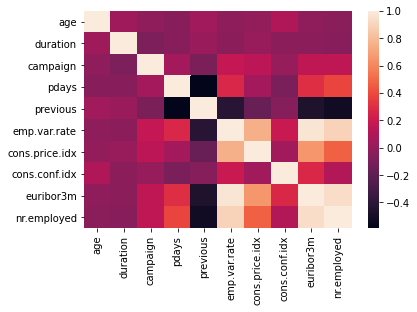

In [ ]:
import seaborn as sns

corr = dataset.corr()
sns.heatmap(corr)

Trough vizualizing the correlation heat map, you can conclude what is already expected from this type of variables, macroeconomic metris are highly correlated. But we can't extract, for now, no relation with the profile of the customers contacted or probabilty of success. 

In [ ]:
sns.pairplot(dataset, hue = 'y', corner = True)

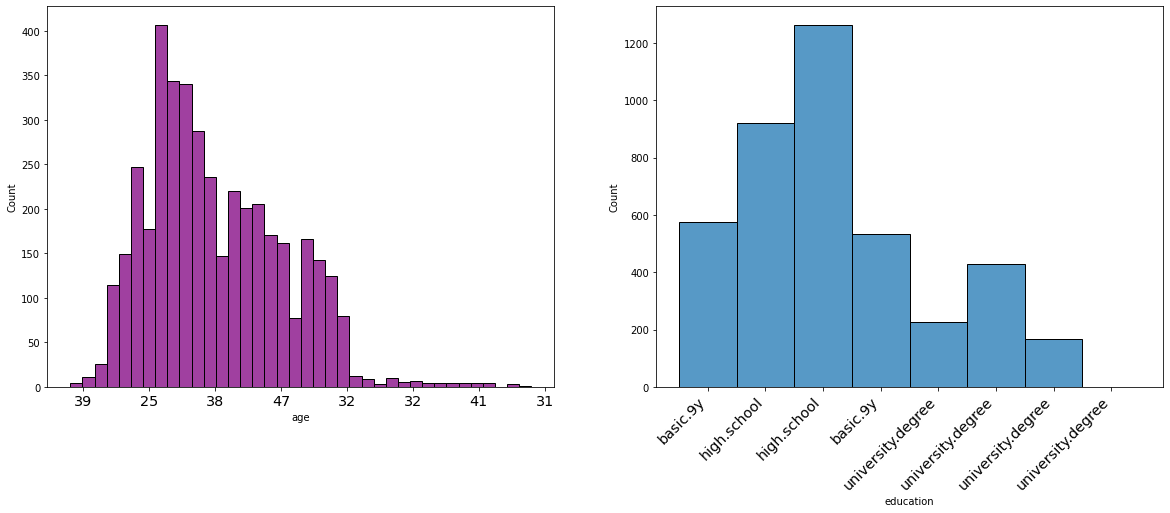

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=False)
ax1 = sns.histplot(data = dataset['age'], color = 'purple', ax = axes[0])
ax2 = sns.histplot(data = dataset['education'], ax = axes[1])

ax2.set_xticklabels(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    labels = dataset['education']
)

ax1.set_xticklabels(
    rotation=0, 
    horizontalalignment='center',
    fontweight='light',
    fontsize='x-large',
    labels = dataset['age'],
    minor = False
)

plt.show()

###Checking age distribuition

##Predicting Success of Telemarketing Call

###Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier_lr = LogisticRegression(random_state = 0)
classifier_lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
classifier_lr.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0])

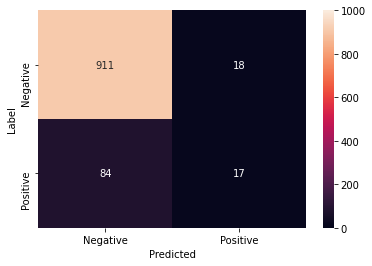

0.9009708737864077


In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
accuracy_lr = accuracy_score(y_test, y_pred)

sns.heatmap(cm, annot=True, xticklabels=['Negative' , 'Positive'], yticklabels=['Negative' , 'Positive'], cmap = 'rocket', vmax = 1000, vmin =0, fmt = 'g')
plt.ylabel("Label")
plt.xlabel("Predicted")
plt.show()

print(accuracy_lr)

###KNN

We will use the Elbow Method to determine best number of clusters

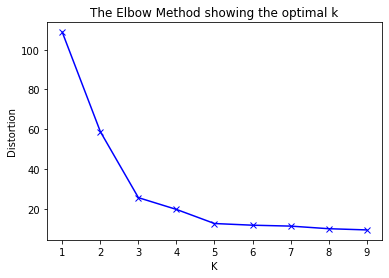

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can determine that the optimal number of neighbors is 5. 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier_knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
y_pred = classifier_knn.predict(X_test)

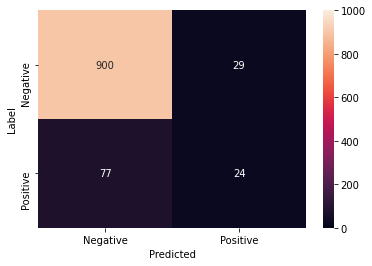

Accuracy Score: 0.8970873786407767


In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, xticklabels=['Negative' , 'Positive'], yticklabels=['Negative' , 'Positive'], cmap = 'rocket', vmax = 1000, vmin =0, fmt = 'g')
plt.ylabel("Label")
plt.xlabel("Predicted")
plt.show()
accuracy_knn = accuracy_score(y_test, y_pred)
print('Accuracy Score:',accuracy_knn)

###SVM 

In [ ]:
# Training the Kernel SVM model on the Training set
from sklearn.svm import SVC
classifier_svm = SVC(kernel = 'poly', random_state = 0, degree=1)
classifier_svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
y_pred = classifier_svm.predict(X_test)

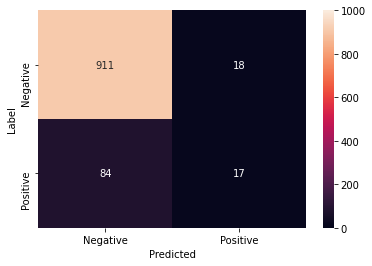

In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, xticklabels=['Negative' , 'Positive'], yticklabels=['Negative' , 'Positive'], cmap = 'rocket', vmax = 1000, vmin =0, fmt = 'g')
plt.ylabel("Label")
plt.xlabel("Predicted")
plt.show()
accuracy_svm = accuracy_score(y_test, y_pred)

###Naive Bayes

In [ ]:
# Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB
classifier_nb = GaussianNB()
classifier_nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
y_pred = classifier_nb.predict(X_test)

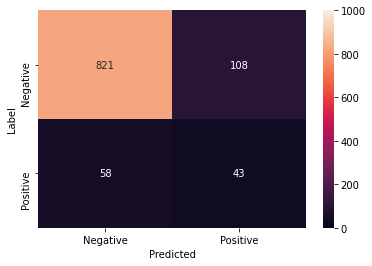

In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, xticklabels=['Negative' , 'Positive'], yticklabels=['Negative' , 'Positive'], cmap = 'rocket', vmax = 1000, vmin =0, fmt = 'g')
plt.ylabel("Label")
plt.xlabel("Predicted")
plt.show()
accuracy_nb = accuracy_score(y_test, y_pred)

###Decision Tree

In [ ]:
# Training the Decision Tree Classification model on the Training set
from sklearn.tree import DecisionTreeClassifier
classifier_dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier_dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

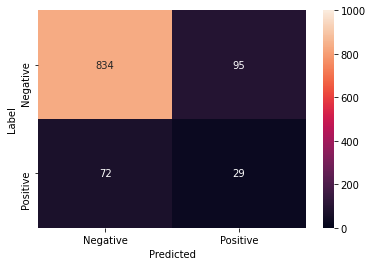

In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier_dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, xticklabels=['Negative' , 'Positive'], yticklabels=['Negative' , 'Positive'], cmap = 'rocket', vmax = 1000, vmin =0, fmt = 'g')
plt.ylabel("Label")
plt.xlabel("Predicted")
plt.show()
accuracy_dt = accuracy_score(y_test, y_pred)

###Random Forest Classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier

classifier_rt = RandomForestClassifier()

classifier_rt.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [14]:
y_pred = classifier_rt.predict(X_test)

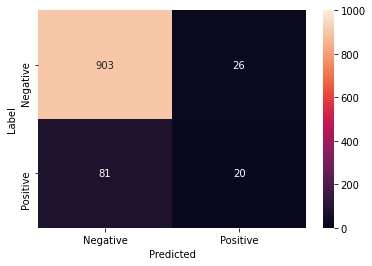

In [15]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, xticklabels=['Negative' , 'Positive'], yticklabels=['Negative' , 'Positive'], cmap = 'rocket', vmax = 1000, vmin =0, fmt = 'g')
plt.ylabel("Label")
plt.xlabel("Predicted")
plt.show()
accuracy_rt = accuracy_score(y_test, y_pred)

###Comparing Accuracy Score for each Model

In [ ]:
print("Accuracy score from all Classifier Models:", '\n', 'Logistic Regression: ', str(accuracy_lr), '\n', 'K-Nearest Neighbors: ', str(accuracy_knn), '\n', 'Support Vector: ', str(accuracy_svm), '\n', 'Naive Bayes: ', str(accuracy_nb), '\n', 'Decision Tree: ', str(accuracy_dt), '\n', 'Random Tree: ', str(accuracy_rt))

Accuracy score from all Classifier Models: 
 Logistic Regression:  0.9009708737864077 
 K-Nearest Neighbors:  0.8970873786407767 
 Support Vector:  0.9009708737864077 
 Naive Bayes:  0.8388349514563107 
 Decision Tree:  0.8378640776699029 
 Random Tree:  0.8941747572815534


##Tuning Hyperparameters with Randomized CV

Firstly, we will tune hyperparameters for the support vector model, since is the one which has the best accuracy score. 
Since I don't understand very much the SVR intuition, this may no be the best way to tune the parameteters, but we will try to get the best results we can anyway, and compare with the results that we had in the previous sections. 

###Defining Parameter Grid 

In [ ]:
#Selecting Kernel types to be tested, we will exclude precomputed kernel due to not being suited for this dataset
svm_kernel = ['linear', 'poly', 'rbf', 'sigmoid']
#Range for degree of polinomial kernel, will be ignored if other kernel is selected
svm_poly_degree = [int(x) for x in np.linspace(start = 1, stop = 15, num = 1)]
#Gamma is the coefficient for RBF Kernel
svm_rbf_gamma = ['scale', 'auto']
#coef0 range which are float and 0.0 by default. It is the independent term for the poly and sigmoid kernels
svm_coef0 = np.arange( 0.0, 10.0+0.0, 0.1 ).tolist()
#Use or not shrinking heuristic
svm_shrinking = [True, False]
#Setting C range
svm_c = [1,10,100,1000]
#Class range affects the way C changes the weight of parameters
svm_class_weight = ['dict', 'balanced']

#Creating random grid
random_grid = {'kernel':svm_kernel,
               'degree':svm_poly_degree,
               'gamma': svm_rbf_gamma,
               'coef0':svm_coef0,
               'shrinking':svm_shrinking,
               'C':svm_c,
               'class_weight':svm_class_weight}

print(random_grid)

###Finding the best parameters with Randomized Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
#Creating classifier
svm = SVC()
#We will do a 3 fold validation, with trough 100 iterations and using all available cores. More than these paremeters we are in risk of overfitting the model
svm_random_search = RandomizedSearchCV(estimator = svm, param_distributions = random_grid, n_iter = 400, cv = 5, verbose=2, random_state=42, n_jobs = -1) #random state is set so this can be reproduced

In [ ]:
# Fit the random search model
svm_random_search.fit(X, y)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 425 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 1131 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed: 25.1min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 32.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=400, n_jobs=-1,
                   param_distributions={'C': [1, 10, 100, 100...
                                                  1.6, 1.7000000000000002, 1.8,
                                                  1.9000000000000001, 2.0, 2.1,
                                                  2.2, 2.3000000000000003,
                                                  2.4000000000000004, 2.5, 2.6,
                                                  2.7, 2.8000000000000003,
          

In [ ]:
#Print the best parameters found by the randomized search
print(svm_random_search.best_params_)

{'shrinking': False, 'kernel': 'sigmoid', 'gamma': 'scale', 'degree': 1, 'coef0': 1.2000000000000002, 'class_weight': 'balanced', 'C': 10}


###Evaluating performance of Random Search

Let's evaluate if using random search, we achieved a significant improvement on our study. 

In [ ]:
#Credit to this part of the code goes to Will Koehrsen wjk68[at]case[dot]edu

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    print(errors)
    mape = 100 * np.mean(errors / test_labels)
    print(mape)
    accuracy = 100 - mape
    
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%. \n'.format(accuracy))
    
    return accuracy

base_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)


best_random = svm_random_search.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


[0 0 0 ... 0 0 1]
nan
Model Performance
Average Error: 0.1068 degrees.
Accuracy = nan%. 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


[0 0 0 ... 0 0 1]
nan
Model Performance
Average Error: 0.0990 degrees.
Accuracy = nan%. 

Improvement of nan%.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


###Predicting outcome with best parameters for our model

In [ ]:
best_classifier = SVC(**svm_random_search.best_params_)
best_classifier.fit(X_train, y_train)
ypred = best_classifier.predict(X_test)

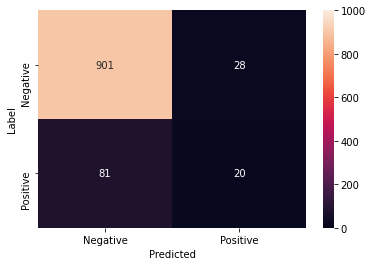

0.8941747572815534


In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, xticklabels=['Negative' , 'Positive'], yticklabels=['Negative' , 'Positive'], cmap = 'rocket', vmax = 1000, vmin =0, fmt = 'g')
plt.ylabel("Label")
plt.xlabel("Predicted")
plt.show()
accuracy_svm_random = accuracy_score(y_test, y_pred)

print(accuracy_svm_random)

In an ununsual outcome, we seen to not have improved or model of SVR Classifier with Randomized Search. With this in mind, let's test this approach with another model. 

##Testing Randomized Search with Random Forest model

###Defining parameter grid

In [19]:
#Defining some number of samples to be tested, after the best parameters are defined, we can refine this variable to achive more optimized results
rt_n_estimators = [10, 100, 500, 1000, 2000]
#This variables changes the way our model will evaluate a quality of each split, there are two methods: gini and entropy. More details on each method in sklearn docs.
rt_criterion = ['gini', 'entropy']
#Now we determine the range values for the minimum number of samples required to split a node
rt_min_samples_split = [2, 5, 7, 9]
#Range of values that will be the requirement for a node be considered a leaf node. Has the effect of smoothing the model.
rt_min_samples_leaf = [1, 2, 4, 6]
#Range for the number of features to evaluate which is the best split. For the details on each method, check sklearn docs. 
rt_max_features = ['auto', 'sqrt', 'log2', None]
#wheter bootstrap samples are used or not
rt_bootstrap = [True, False]
#if bootstrap = True, decide if wheter or not use out-of-bag samples to calculate the generalization score
rt_oob_score = [True, False]
#experimenting with this parameter
rt_max_samples = [None,0.5, 2, 4, 6]

#Creating random grid

random_grid = {
    'n_estimators': rt_n_estimators,
    'criterion': rt_criterion,
    'min_samples_split': rt_min_samples_split,
    'min_samples_leaf': rt_min_samples_leaf,
    'max_features': rt_max_features,
    'bootstrap': rt_bootstrap,
    'oob_score': rt_oob_score,
    'max_samples': rt_max_samples
}

print(random_grid)

{'n_estimators': [10, 100, 500, 1000, 2000], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 5, 7, 9], 'min_samples_leaf': [1, 2, 4, 6], 'max_features': ['auto', 'sqrt', 'log2', None], 'bootstrap': [True, False], 'oob_score': [True, False], 'max_samples': [None, 0.5, 2, 4, 6]}


###Finding the best parameters with Randomized Search

In [20]:
from sklearn.model_selection import RandomizedSearchCV
#Creating classifier
rt = RandomForestClassifier(n_jobs = -1)
#We will do a 3 fold validation, with trough 100 iterations and using all available cores. More than these paremeters we are in risk of overfitting the model
rt_random_search = RandomizedSearchCV(estimator = rt, param_distributions = random_grid, n_iter = 200, cv = 3, verbose=2, n_jobs = -1)

In [21]:
#searching for the best parameters

rt_random_search.fit(X, y)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 12.3min
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 16.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

The best parameters selected by the RandomSearchCV algorithm are:

In [26]:
print(rt_random_search.best_params_)

{'oob_score': True, 'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_samples': 0.5, 'max_features': 'log2', 'criterion': 'entropy', 'bootstrap': True}


In [24]:
#predicting results using test set
#note: by using random search, our model retains the best parameters which also can be accessed with .best_parameters_ property.
y_pred = rt_random_search.predict(X_test)

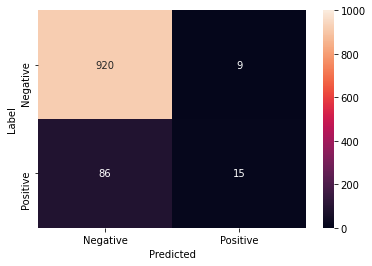

0.9077669902912622


In [25]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, xticklabels=['Negative' , 'Positive'], yticklabels=['Negative' , 'Positive'], cmap = 'rocket', vmax = 1000, vmin =0, fmt = 'g')
plt.ylabel("Label")
plt.xlabel("Predicted")
plt.show()
accuracy_rt_random = accuracy_score(y_test, y_pred)
print(accuracy_rt_random)

Using this Random Forest we achieved a slightly better improvement (< 1%) on our accuracy score, but it's notable that the number of false positives are reduced considerably (aprx. 66% reduction). False positives where the biggest innacuracy of our previous models, and for that the outcome is sactisfactory. 

* But yet, we have more false negatives than true positives. We can fix these using some clever techniques. 

###Adjusting the decision threshold

In [ ]:
###TODO